# COLLAB

In [1]:
### loading the data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dbvieira","key":"ba29a2c62ed8d384d9df88b152219dde"}'}

In [ ]:
#Script to download and unpach the kaggle content
!ls -lha kaggle.json


!pip install -q kaggle




!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!chmod 600 /root/.kaggle/kaggle.json


!pwd


!kaggle datasets list


!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria


!unzip cell-images-for-detecting-malaria.zip

In [4]:
#Deleting useless content from storage
!rm -rf cell_images/cell_images
!rm cell_images/Parasitized/Thumbs.db
!rm cell_images/Uninfected/Thumbs.db

In [5]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 9.5 MB/s eta 0:00:00


# HEADER

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras import mixed_precision
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random
import keras_tuner as kt
import pathlib

In [2]:
# Suppress TPU messages which start with "Executing op"

import sys, re, logging

class Filter(object):
    def __init__(self, stream):
        self.stream = stream

    def __getattr__(self, attr_name):
        return getattr(self.stream, attr_name)

    def write(self, data):
        if not data.startswith("Executing op"):
            self.stream.write(data)
            self.stream.flush()

    def flush(self):
        self.stream.flush()
  
sys.stdout = Filter(sys.stdout)
sys.stderr = Filter(sys.stderr)

logger = logging.getLogger(__name__)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(True)

# If the following line doesn't output "Tesla T4", you can try getting access to
# another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
# re-running this cell.
!nvidia-smi -L

Num GPUs Available:  1
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-2f6ca3a6-0a55-0ce5-cd9b-fde2db78c979)


In [4]:
data_dir = 'cell_images'


#Reading and spliting the dataset in training and validation using 80/20 cross-validation
image_size = (50,50)
batch_size = 32
validation_split = 0.2
color_mode = 'rgb'
seed = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  shuffle = True,
  label_mode = 'categorical',
  image_size=image_size,
  color_mode = color_mode,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed= seed,
  label_mode = 'categorical',
  color_mode = color_mode,
  image_size=image_size,
  batch_size=batch_size)

#Printing Classes Names
class_names = train_ds.class_names
print('\nLabels:', class_names)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.

Labels: ['Parasitized', 'Uninfected']


In [5]:
#Prefetching the dataset to improve the performance during the train
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Turn on mixed precision training to improve the processing time of the model
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [6]:
def preprocess_img(image, label):
  # image = image/255. # scale image values
  return tf.cast(image, tf.float32)/255, label

#preprocessing the datasets, normalizing the values
train_data = train_ds.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_ds.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
#creating model validation function to evaluate and compare models
def model_validation(model, val_data):
  # Check the accuracy of our model
  loss, accuracy = model.evaluate(val_data)
  print(f"Model loss on test set: {loss}")
  print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

  # Make predictions
  y_preds = model.predict(val_data)

  id = 0
  temp = 0
  tempx = 0
  for x,y in val_data:
    if id == 0:
      tempx = x
      temp = y
      id+=1
    else:
      tempx = np.concatenate([tempx,x])
      temp = np.concatenate([temp, y])

  y_pred = (y_preds > 0.5)
  temp = (temp > 0.5)

  # Note: The following confusion matrix code is a remix of Scikit-Learn's 
  # plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
  # and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 
  import itertools

  figsize = (10, 10)

  # Create the confusion matrix
  cm = confusion_matrix(temp[:,0],y_pred[:,0])
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0]

  # Let's prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
  fig.colorbar(cax)

  # Create classes
  classes = True

  if classes:
    labels = class_names
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.xaxis.label.set_size(20)
  ax.yaxis.label.set_size(20)
  ax.title.set_size(20)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i, j] > threshold else "black",
            size=15)

# TUNNING

In [8]:
# Create the model
def create_model_wrapper(input_dim, padding_opt, layers_size, units_sizes, learning_rates, hidden_activations, output_activations):
  def create_model(hp):

    model = Sequential([layers.Input(input_dim)])

    # HP multi-layer perceptron: number of hidden layers
    n_layers = hp.Int('layers', 
                      min_value=layers_size["min_value"], 
                      max_value=layers_size["max_value"], 
                      step=layers_size["step"])
    
    # n_kernels = hp.Int('kernel', 
    #                   min_value=kernel_sizes["min_value"], 
    #                   max_value=kernel_sizes["max_value"], 
    #                   step=kernel_sizes["step"])
    
    af_padding = hp.Choice('padding', padding_opt)

    af_hidden = hp.Choice('activation', values=hidden_activations)

    h_units = hp.Int('units',
                      min_value=units_sizes["min_value"], 
                      max_value=units_sizes["max_value"], 
                      step=units_sizes["step"])

    for i in range(0, n_layers + 1):
      model.add(layers.Conv2D(32*2**(i), 3 ,padding= af_padding, activation= af_hidden))
      model.add(layers.MaxPooling2D())
      model.add(layers.Dropout(0.2))

    af_output = hp.Choice('output', values=output_activations)

    model.add(layers.Flatten())
    model.add(layers.Dense(h_units, activation= af_hidden))
    model.add(layers.Dense(2, activation = af_output))

    # Compile the model before the return
    lr =  hp.Choice('learning_rate', values=learning_rates)
    model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                  metrics=['accuracy'])
    return model
  return create_model

In [9]:
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)


# Define parameters for the wrapper function
padding_sizes = ['valid', 'same']
layers_size = {"min_value": 1, "max_value": 3, "step": 1}
units_sizes = {"min_value": 128, "max_value": 512, "step": 128}
learning_rates = [0.01, 0.001]


hidden_activations = ["relu"]
output_activations = ["softmax"]

hypermodel = create_model_wrapper((50,50,3), padding_sizes, layers_size, units_sizes, learning_rates, hidden_activations, output_activations)

# Create an instance of tuner
tuner = kt.RandomSearch(hypermodel, 
                        objective='val_accuracy',
                        directory="my_first_keras_tuner",
                        overwrite=True,                        
                        executions_per_trial=1, 
                        max_trials=10,
                        seed=seed)

In [29]:
# Calculate the class weights 
tuner.search(train_data, validation_data=val_data,
             epochs=5, verbose=1)

Trial 15 Complete [00h 00m 52s]
val_accuracy: 0.5084376931190491

Best val_accuracy So Far: 0.959354043006897
Total elapsed time: 00h 15m 00s


In [30]:
tuner.results_summary()

Results summary
Results in my_first_keras_tuner/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
layers: 3
padding: same
activation: relu
units: 128
output: softmax
learning_rate: 0.001
Score: 0.959354043006897

Trial 03 summary
Hyperparameters:
layers: 2
padding: valid
activation: relu
units: 512
output: softmax
learning_rate: 0.001
Score: 0.957720935344696

Trial 09 summary
Hyperparameters:
layers: 1
padding: valid
activation: relu
units: 256
output: softmax
learning_rate: 0.001
Score: 0.957720935344696

Trial 00 summary
Hyperparameters:
layers: 1
padding: same
activation: relu
units: 384
output: softmax
learning_rate: 0.001
Score: 0.9571765661239624

Trial 10 summary
Hyperparameters:
layers: 2
padding: valid
activation: relu
units: 256
output: softmax
learning_rate: 0.001
Score: 0.9557248950004578

Trial 04 summary
Hyperparameters:
layers: 3
padding: valid
activation: relu
units: 256
output: softmax
learning_r

In [31]:
# Get the optimal hyperparameters
hps = tuner.get_best_hyperparameters()[0]
print(" > layers: {} \n > padding: {} \n > units: {} \n > learning_rate: {}".format(hps.get('layers'), hps.get('padding'),  hps.get('units'), hps.get('learning_rate')))

best_model = tuner.get_best_models()[0]
best_model.save('models/best_model')

 > layers: 3 
 > padding: same 
 > units: 128 
 > learning_rate: 0.001


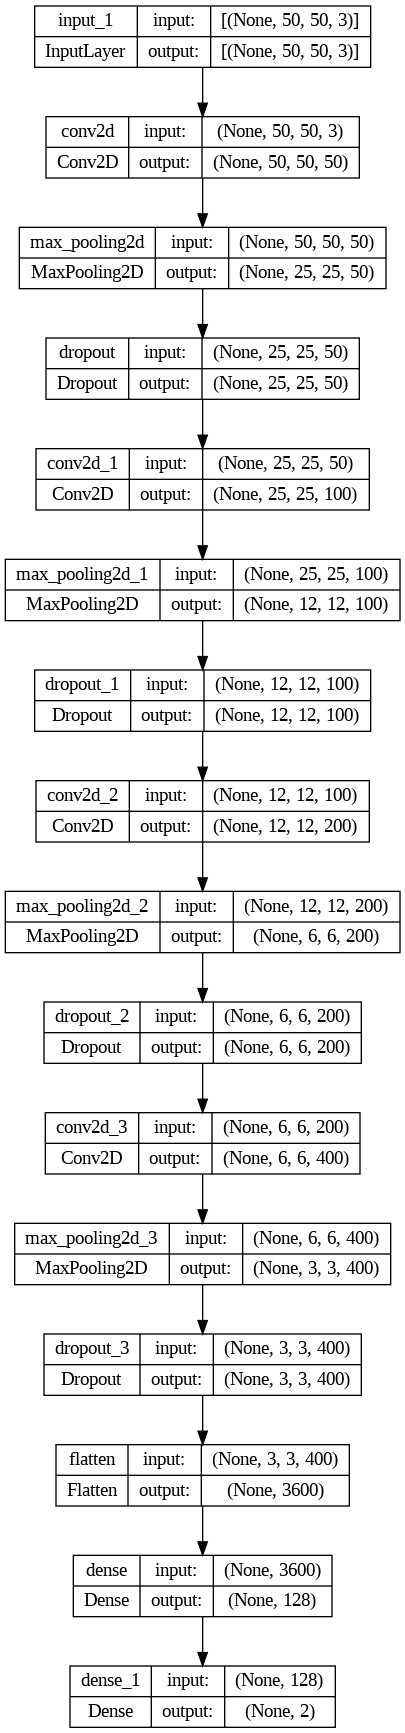

In [32]:
# See the inputs and outputs of each layer
plot_model(best_model, show_shapes=True)

173/173 [==============================] - 2s 8ms/step - loss: 0.1191 - accuracy: 0.9594
Model loss on test set: 0.11907138675451279
Model accuracy on test set: 95.94%
173/173 [==============================] - 1s 6ms/step


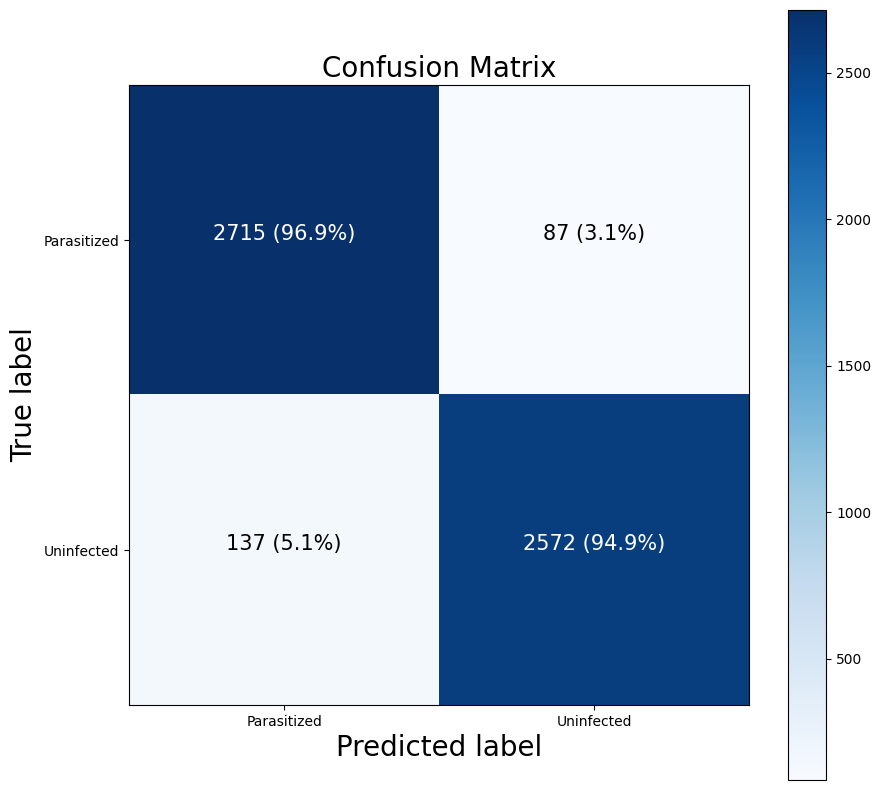

In [33]:
best_model = tuner.get_best_models()[0]
model_validation(best_model, val_data)

# COMPARISON BETWEEN HANDMADE AND TUNNED

In [14]:
base_model = load_model('models/base_model')

best_model = load_model('models/best_model')

In [11]:
base_history = base_model.fit(
  train_data,
  validation_data=val_data,
  epochs=5,
  verbose=1
  )

best_history = best_model.fit(
  train_data,
  validation_data=val_data,
  epochs=5,
  verbose=1
  )

Epoch 1/5
689/689 [==============================] - 99s 55ms/step - loss: 0.2652 - accuracy: 0.8942 - val_loss: 0.1760 - val_accuracy: 0.9428
Epoch 2/5
689/689 [==============================] - 7s 11ms/step - loss: 0.1645 - accuracy: 0.9465 - val_loss: 0.1488 - val_accuracy: 0.9503
Epoch 3/5
689/689 [==============================] - 7s 11ms/step - loss: 0.1422 - accuracy: 0.9515 - val_loss: 0.1666 - val_accuracy: 0.9374
Epoch 4/5
689/689 [==============================] - 7s 11ms/step - loss: 0.1330 - accuracy: 0.9556 - val_loss: 0.1452 - val_accuracy: 0.9521
Epoch 5/5
689/689 [==============================] - 13s 19ms/step - loss: 0.1254 - accuracy: 0.9579 - val_loss: 0.1349 - val_accuracy: 0.9523
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\danie\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\danie\AppData\Local\Temp\ipykernel_29280\251044616.py", line 8, in <module>
    best_history = best_model.fit(
NameError: name 'best_model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\danie\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "c:\Users\danie\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1310, in structured_traceback
    return FormattedTB.structured_traceback(
  File "c:\Users\danie\miniconda3\lib\site-packages\IPython\core\ultratb.py", line 1199, in structured_traceback
    return VerboseTB.structured_traceback(
  File "c:\Users\danie\miniconda3\lib\site-p

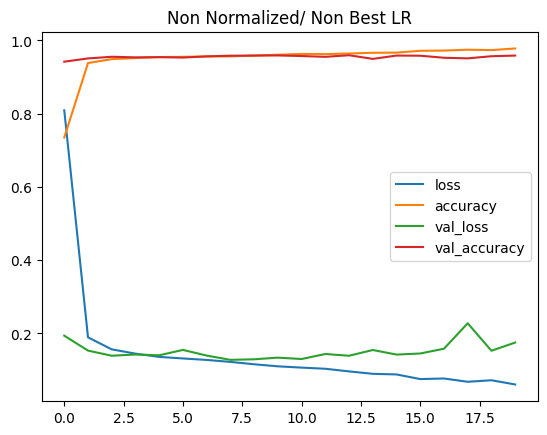

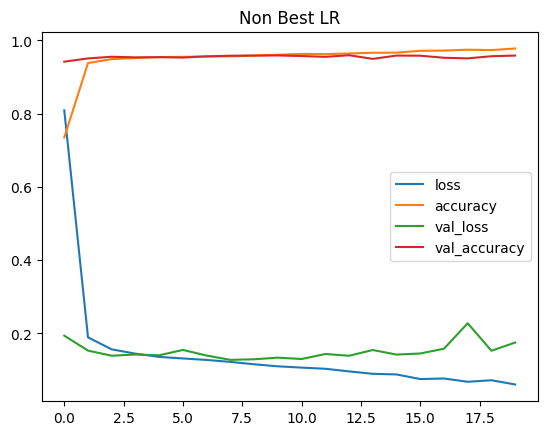

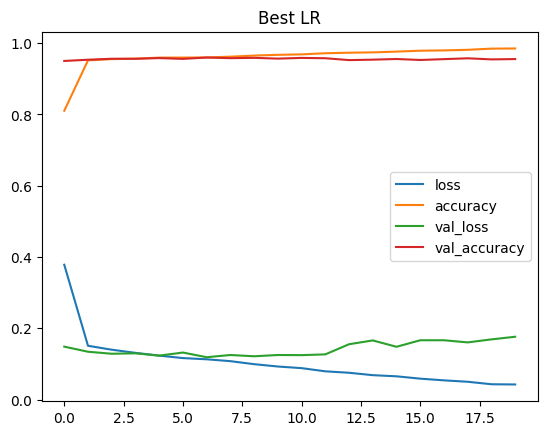

In [ ]:
# Plot non-normalized data loss curves with default LR
pd.DataFrame(base_history.history).plot(title="Base Model")
# Plot normalized data loss curves with default LR
pd.DataFrame(best_history.history).plot(title="Best Model")

173/173 [==============================] - 1s 4ms/step


<ipython-input-61-88e837fe9bc0>:31: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.title(class_names[label])


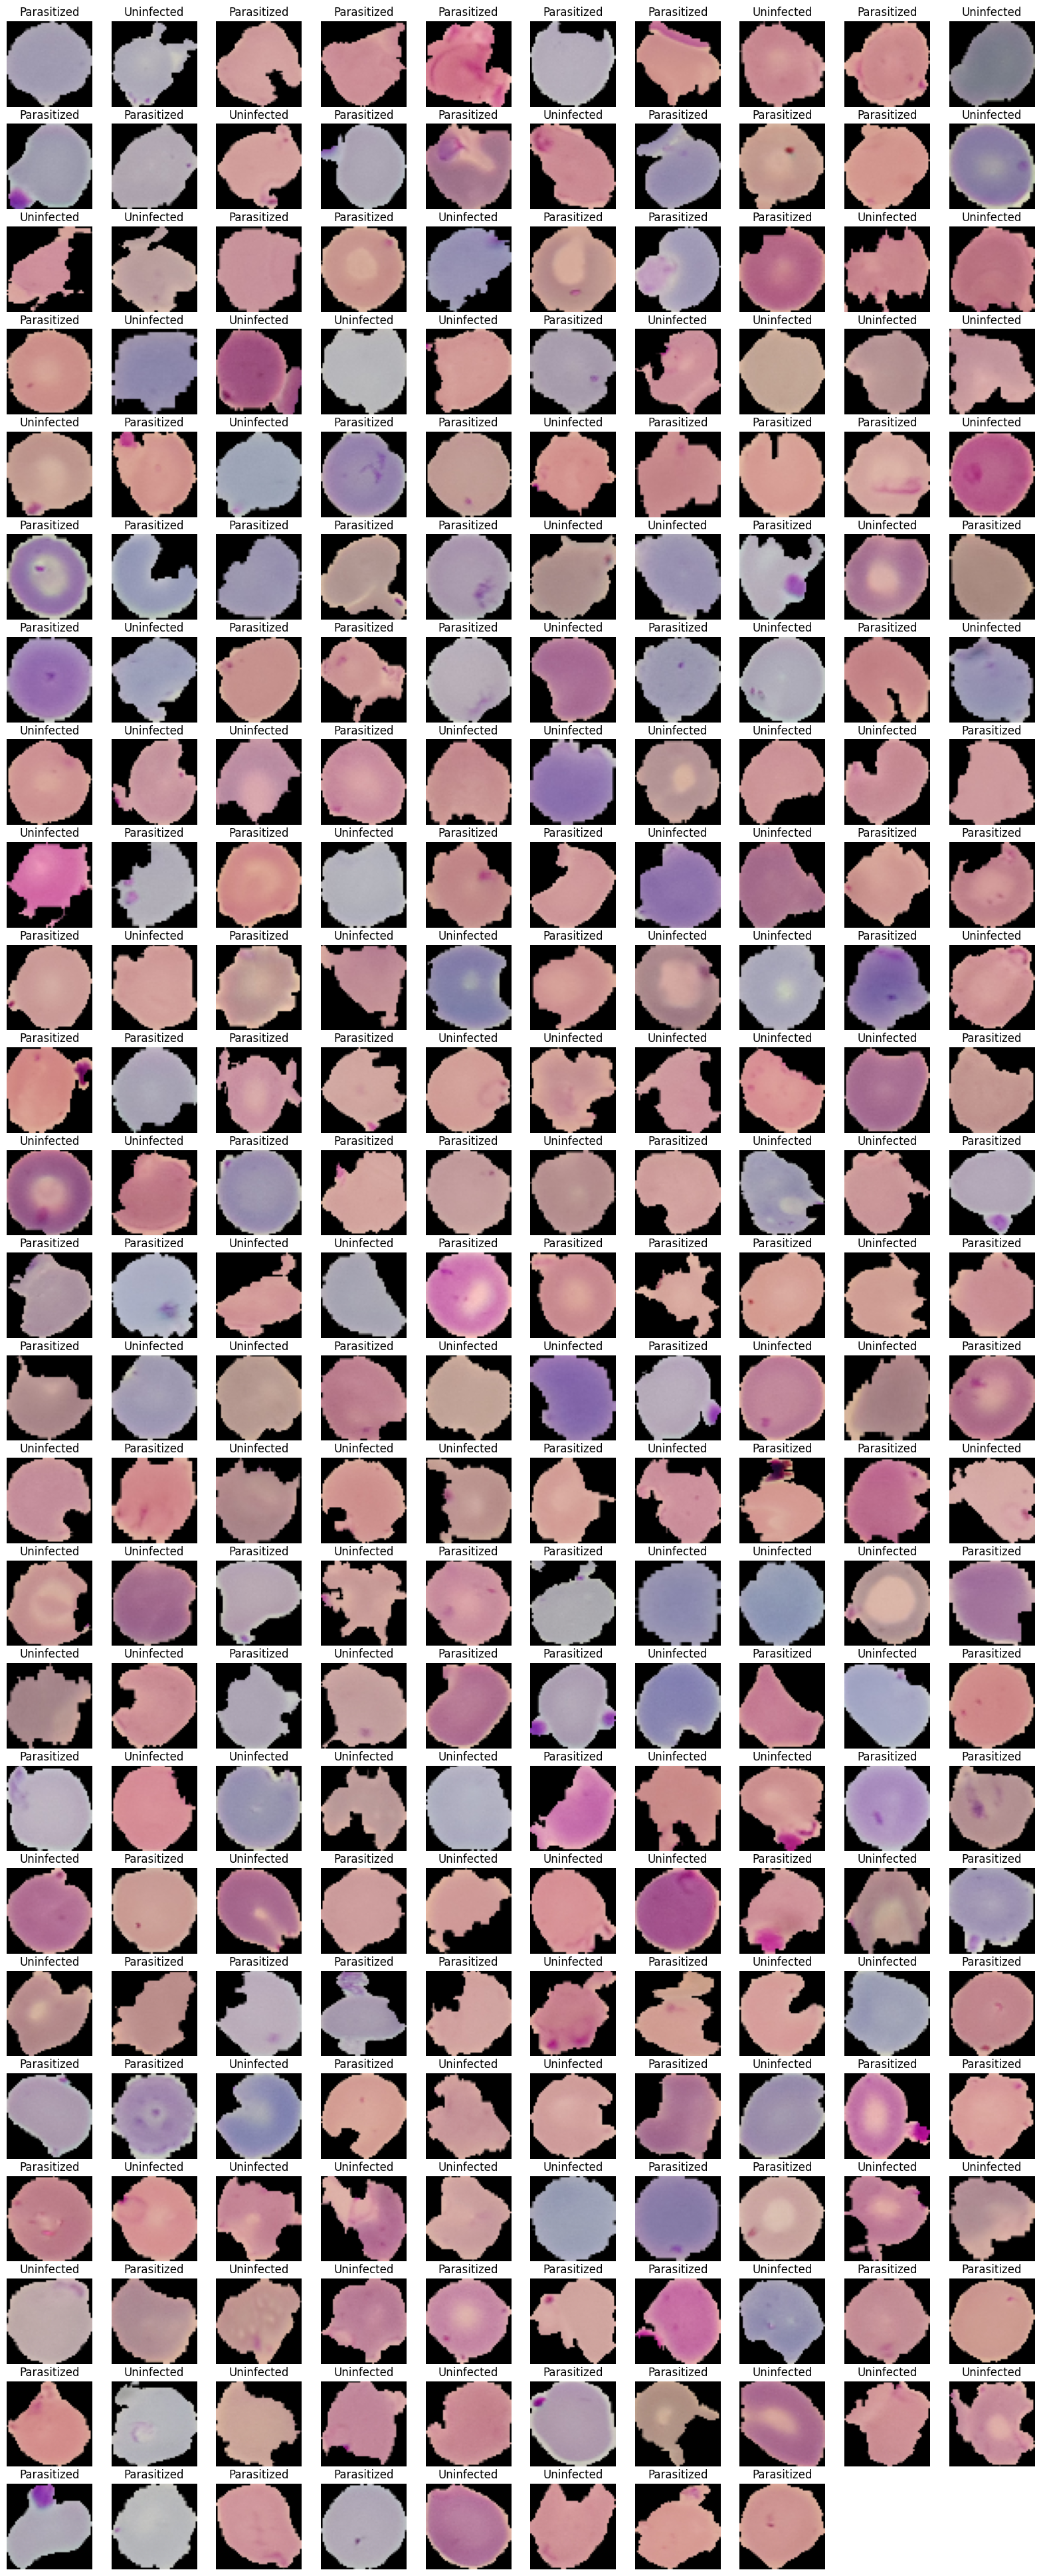

In [ ]:
#ploting Wrong Predictions
y_preds = best_model.predict(val_data)

id = 0
temp = 0
tempx = 0
for x,y in val_data:
  if id == 0:
    tempx = x
    temp = y
    id+=1
  else:
    tempx = np.concatenate([tempx,x])
    temp = np.concatenate([temp, y])

y_pred = (y_preds > 0.5)
temp = (temp > 0.5)

equal = (y_pred[:,0] == temp[:,0])

error_list = []
for i in range (0,equal.size):
  if not equal[i]:
    error_list.append((tempx[i], temp[i,0]))

plt.figure(figsize=(20,100))
i=0
for images, label in error_list:
      ax = plt.subplot(50, 10, i+1)
      plt.imshow(images)
      plt.title(class_names[label])
      plt.axis('off')
      i+=1